In [1]:
import wfdb
from wfdb import processing
import os
import matplotlib.pyplot as plt
import wfdb_custom
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import io
import scaleogram as scg


Bad key "text.kerning_factor" on line 4 in
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
### Set Dataset Path
dataset_paths = [ "/home/ec2-user/SageMaker/physionet.org/files/challenge-2016/1.0.0/training-a/" , "/home/ec2-user/SageMaker/datasets/Physionet2016_a/DenoisedEMD2016/","/home/ec2-user/SageMaker/datasets/Physionet2016_a/DenoisedEMD_ECG2016/"]
files        = [ os.listdir(dataset_paths[0]), os.listdir(dataset_paths[1]), os.listdir(dataset_paths[2])]

In [3]:
#extract .wav file names only (folder has .hea , .dat as well)
wav_files  = sorted([file for file in files[0] if '.wav' in file])
pcgmat_files  = sorted([file for file in files[1] if '.mat' in file])
ecgmat_files  = sorted([file for file in files[2] if '.mat' in file])

In [12]:
def pcgmat2np(x):
    data = scipy.io.loadmat(dataset_paths[1] + pcgmat_files[x])  # eg: 'D_A00001.mat'
    wave = data['y'] # numpy array
    wave = wave.reshape(wave.shape[0])
    return wave

In [13]:
def ecgmat2np(x):
    data = scipy.io.loadmat(dataset_paths[2] + ecgmat_files[x])  # eg: 'D_A00001.mat'
    wave = data['y'] # numpy array
    wave = wave.reshape(wave.shape[0])
    return wave

In [49]:
def plot_wavelet(a,ecg=False,save_path=None):
    scg.set_default_wavelet('cmor1.5-1.0')
    scales = np.arange(7, 450)
    #scales = np.arange(2, 450)

    fs = 2000
    xcg = a
    t = np.array(range(len(xcg)-1))/fs
    cwt = scg.CWT(t, xcg,scales)
    fig = scg.cws(cwt, figsize=(9,5),yaxis='frequency',yscale = 'log',cscale='linear',xlabel="Time (s)",coi=False)
    
    if(save_path!=None):
        plt.savefig(save_path)
    #plt.show()
    #plt.clf()
    

In [50]:
export_paths = ["/home/ec2-user/SageMaker/datasets/Physionet2016_a/new_split_based_on_denoised/raw/",
                "/home/ec2-user/SageMaker/datasets/Physionet2016_a/new_split_based_on_denoised/denoised/"]

In [51]:
def metadata(x,s=100,e=14000):
    '''
        Accepts: a file id, x
        Returns: Prints parameters about a specific record
                 Plots the locally detected peaks
    
    '''
    
    #rec = wav_files[x][:-4]
    rec = pcgmat_files[x][2:7]
    
    record = wfdb.rdrecord(dataset_paths[0] +rec) 

    #print(record.sig_name)
    #print(record.comments)
    #print(record.record_name)
    #print(record.fs)
    
    a = record.p_signal[:,0]
    b = record.p_signal[:,1]
    
    pcg_p = wfdb.processing.find_local_peaks(record.p_signal[:,0],1000) 
    ecg_p = wfdb.processing.find_local_peaks(record.p_signal[:,1],1000) 
    peaks = [pcg_p , ecg_p]
    
    plot_wavelet(b[s:e])
    #save_path = export_paths[0] + "pcg/lop.png"
    wfdb_custom.plot_wfdb(s,e,peaks,record=record, title='Record ' + rec + ' from PhysioNet Challenge 2016' + ' => ' + record.__dict__['comments'][0],figsize=(12,5), time_units = 'samples',ecg_grids=[1]) 
    
    ##Denoised
    pcg_wave = pcgmat2np(x)
    ecg_wave = ecgmat2np(x)
    if(len(pcg_wave)==0 or len(ecg_wave)==0):
        print("==== ERROR ==== ", x)
        return
    
    pcg_p = wfdb.processing.find_local_peaks(pcg_wave,1000) 
    ecg_p = wfdb.processing.find_local_peaks(ecg_wave,1000) 
    peaks = [pcg_p , ecg_p] 
    
    wave = [pcg_wave , ecg_wave]
    
    plot_wavelet(ecg_wave[s:e])
    print("Denoised Waves")
    wfdb_custom.custom_plot_signal(s,e,peaks,wave,figsize=(12,5))
    
    
    e_p = -1
    
    '''
    Scalogram Generation
    for i in range(0,len(pcg_p)):

        s_p = pcg_p[i]
        if(s_p < e_p):
            continue
        
        e_p   = s_p + 7000
        #print(s_p,e_p)
        
        rec = mat_files[x][2:7]
        if(record.comments[0]=='Abnormal'):
            rec = rec + "_" + str(s_p) + '_A.tiff'
        else:
            rec = rec + "_" + str(s_p) + '_N.tiff'
        
        plot_wavelet(a[s_p:e_p]   ,save_path=export_paths[0] + rec)
        plot_wavelet(wave[s_p:e_p],save_path=export_paths[1] + rec)
    ''' 

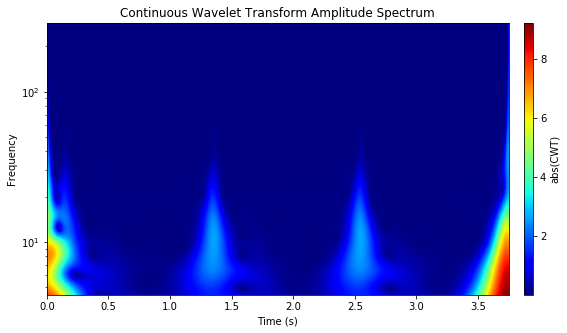

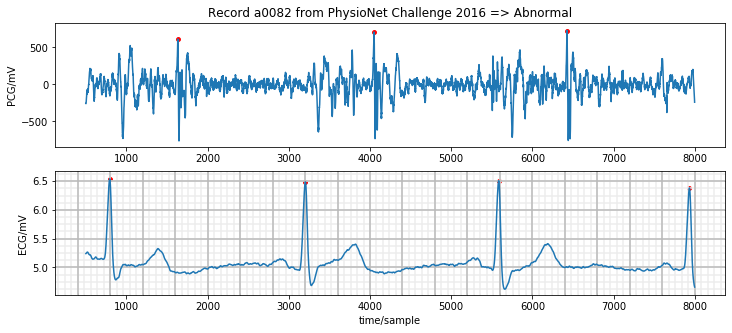

Denoised Waves


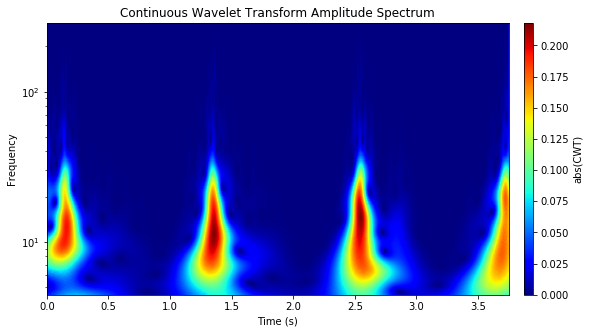

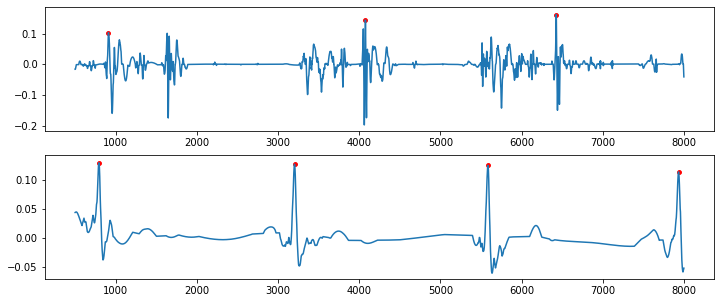

In [53]:
metadata(80,500,8000)

In [ ]:
for i in range(0,len(mat_files)):
    metadata(i)

In [ ]:
wave = mat2np(26)
plt.plot(wave)

In [ ]:
#!aws s3 cp /home/ec2-user/SageMaker/datasets s3://intelliscope-data/datasets --recursive